In [111]:
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from google.colab import drive

In [112]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/new_features.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df["patient_id"] = df["patient_id"].astype("int")
df["lead_id"] = df["lead_id"].astype("int")

In [114]:
df.head(5)

,patient_id,lead_id,pr_ratio,rr_distance,p_energy,t_energy,pq_distance,qt_interval,st_slope,pr_slope,qrs_energy,rsq,heart_rate,edr_time_ratio,edr_energy_ratio
0,0,1,-0.054317,377.083333,-3297.249202,5756.845777,57.000000,0.404318,3.122865,8.642640,8564.971669,913.046274,0.159116,1.007608,1.011732
1,0,2,0.173118,377.166667,9.640745,2769.939236,57.692308,0.441143,1.907872,2.284969,1435.067840,444.574330,0.159081,0.876788,0.744761
2,0,3,0.803948,411.090909,3226.989388,861.597898,46.833333,0.373397,5.337444,0.085836,-1520.994131,447.789323,0.145953,0.959859,0.946903
3,0,4,0.763358,383.000000,2931.324322,2988.418158,66.461538,0.271741,8.208612,0.346546,48.321557,401.243304,0.156658,1.140411,1.100461
4,0,5,-0.058833,411.272727,-3019.002055,4359.392590,43.916667,0.360466,2.422612,9.218017,8780.695173,786.025130,0.145889,1.045801,0.947137


In [115]:
df = df[["patient_id","lead_id", "edr_time_ratio", "edr_energy_ratio"]]
df.head()

,patient_id,lead_id,edr_time_ratio,edr_energy_ratio
0,0,1,1.007608,1.011732
1,0,2,0.876788,0.744761
2,0,3,0.959859,0.946903
3,0,4,1.140411,1.100461
4,0,5,1.045801,0.947137


In [116]:
5# we have 2164 patients
# 20% of 2164 is approximately equals to 433 patients
# randomly generating 433 patients
import random
all_patients = list(range(0, 2164))
selected_patients = random.sample(all_patients, 433)

In [117]:
folder_path = "/content/drive/MyDrive/DIS_Dr_Liu/"
small_X_path = folder_path + "small_X.npy"
small_y_path = folder_path + "small_y.npy"
ecg_X = np.load(small_X_path, allow_pickle=True)
ecg_y = np.load(small_y_path, allow_pickle=True)

print('X: ', ecg_X.shape)
print('y: ', ecg_y.shape)

print(ecg_X[0])
print(ecg_y[0])

X:  (2164, 12, 5000)
y:  (2164,)
[[  10   15   -5 ... -107  -88  -39]
 [ -20   -5  -20 ... -122 -112  -63]
 [ -30  -20  -15 ...  -15  -24  -24]
 ...
 [  34   29   49 ...  137  127   83]
 [ -29  -34  -10 ...   83   73   20]
 [ -39  -59  -34 ...  142  122   39]]
1


In [118]:
y = ecg_y
target_df = pd.DataFrame()
target_df["patient_id"] = all_patients
target_df["target"] = y
target_df["patient_id"] = target_df["patient_id"].astype("int")
target_df["target"] = target_df["target"].astype("int")

In [119]:
merged_df = pd.merge(df, target_df, on='patient_id', how='inner')

In [120]:
merged_df.isna().sum()

patient_id             0
lead_id                0
edr_time_ratio      2936
edr_energy_ratio    2936
target                 0
dtype: int64

In [121]:
merged_df.dropna(inplace=True)
merged_df

,patient_id,lead_id,edr_time_ratio,edr_energy_ratio,target
0,0,1,1.007608,1.011732,1
1,0,2,0.876788,0.744761,1
2,0,3,0.959859,0.946903,1
3,0,4,1.140411,1.100461,1
4,0,5,1.045801,0.947137,1
...,...,...,...,...,...
25963,2163,8,0.953257,0.937737,0
25964,2163,9,1.879499,1.736153,0
25965,2163,10,1.033777,1.018536,0
25966,2163,11,1.602314,1.578354,0


In [122]:
merged_df.to_csv("/content/drive/MyDrive/DIS_Dr_Liu/new_features_merged.csv")

# Models on all data using Standard Normalization

In [123]:
# merged_df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/new_features.csv")
# merged_df.drop("Unnamed: 0", axis=1, inplace=True)
# merged_df.dropna(inplace=True)

In [124]:
merged_df

,patient_id,lead_id,edr_time_ratio,edr_energy_ratio,target
0,0,1,1.007608,1.011732,1
1,0,2,0.876788,0.744761,1
2,0,3,0.959859,0.946903,1
3,0,4,1.140411,1.100461,1
4,0,5,1.045801,0.947137,1
...,...,...,...,...,...
25963,2163,8,0.953257,0.937737,0
25964,2163,9,1.879499,1.736153,0
25965,2163,10,1.033777,1.018536,0
25966,2163,11,1.602314,1.578354,0


In [125]:
merged_df["target"].value_counts()

0    11610
1    11422
Name: target, dtype: int64

In [126]:
# merged_df = merged_df[merged_df["lead_id"] == 1]
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

X = merged_df.drop(["patient_id", "lead_id", "target"], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,edr_time_ratio,edr_energy_ratio
0,0.336547,0.398534
1,0.228370,0.222385
2,0.270832,0.260660
3,-0.160502,-0.185602
4,-0.080835,-0.027458
...,...,...
23027,-0.259417,-0.190749
23028,-0.017183,-0.015091
23029,0.577349,0.696147
23030,-0.462616,-0.463332


# K-Fold

In [127]:
from sklearn.model_selection import cross_val_score, train_test_split

## Training and Testing on Complete Data

In [128]:
y = merged_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [129]:
len(X_train), len(X_test)

(18425, 4607)

In [130]:
y.value_counts()

0    11610
1    11422
Name: target, dtype: int64

## Logistic Regression

In [131]:
logress_model = LogisticRegression()

k_fold = 5
cv_scores = cross_val_score(logress_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

logress_model.fit(X_train, y_train)

log1_pred = logress_model.predict(X_test)

Cross-Validation Scores: [0.50176391 0.50230665 0.49769335 0.49877883 0.50040706]
Mean CV Accuracy: 0.5002


In [132]:
accuracy = accuracy_score(y_test, log1_pred)
f1 = f1_score(y_test, log1_pred)
precision = precision_score(y_test, log1_pred)
recall = recall_score(y_test, log1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5126980681571521
F1 Score: 0.007076514816452897
Precision: 0.5
Recall: 0.0035634743875278397


## Decision Trees

In [133]:
decision_tree_model = DecisionTreeClassifier()

k_fold = 5
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

decision_tree_model.fit(X_train, y_train)

dt1_pred = decision_tree_model.predict(X_test)

Cross-Validation Scores: [0.49769335 0.50284939 0.49335142 0.4990502  0.4890095 ]
Mean CV Accuracy: 0.4964


In [134]:
accuracy = accuracy_score(y_test, dt1_pred)
f1 = f1_score(y_test, dt1_pred)
precision = precision_score(y_test, dt1_pred)
recall = recall_score(y_test, dt1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5037985673974387
F1 Score: 0.4935755427558707
Precision: 0.49096518289995594
Recall: 0.4962138084632517


## Random Forest

In [135]:
rf_model = RandomForestClassifier()

k_fold = 5
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

rf_model.fit(X_train, y_train)

rf1_pred = rf_model.predict(X_test)

Cross-Validation Scores: [0.4936228  0.49986431 0.49443691 0.49497965 0.49579376]
Mean CV Accuracy: 0.4957


In [136]:
accuracy = accuracy_score(y_test, rf1_pred)
f1 = f1_score(y_test, rf1_pred)
precision = precision_score(y_test, rf1_pred)
recall = recall_score(y_test, rf1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.507054482309529
F1 Score: 0.49789962414326777
Precision: 0.4942932396839333
Recall: 0.5015590200445434


## Xgboost

In [137]:
xgboost_model = xgb.XGBClassifier(subsample=0.8, max_depth= 6, learning_rate= 0.2, colsample_bytree= 1.0)

k_fold = 5
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

xgboost_model.fit(X_train, y_train)

xgb1_pred = xgboost_model.predict(X_test)

Cross-Validation Scores: [0.50773406 0.51370421 0.48032564 0.49932157 0.49850746]
Mean CV Accuracy: 0.4999


In [138]:
accuracy = accuracy_score(y_test, xgb1_pred)
f1 = f1_score(y_test, xgb1_pred)
precision = precision_score(y_test, xgb1_pred)
recall = recall_score(y_test, xgb1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5137833731278489
F1 Score: 0.4862385321100917
Precision: 0.5011820330969267
Recall: 0.47216035634743875


## SVM

In [139]:
svm_model = SVC()

k_fold = 5
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

Cross-Validation Scores: [0.50963365 0.50474898 0.49769335 0.49470828 0.5109905 ]
Mean CV Accuracy: 0.5036


In [140]:
print("Testing Performance")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Testing Performance
Accuracy: 0.5103103972216193
F1 Score: 0.38528610354223436
Precision: 0.496140350877193
Recall: 0.3149220489977728


## Naive Bayes

In [141]:
# Create Naive Bayes model
naive_bayes_model = GaussianNB()

k_fold = 5
cv_scores = cross_val_score(naive_bayes_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

naive_bayes_model.fit(X_train, y_train)

# Make predictions
naive_bayes_pred = naive_bayes_model.predict(X_test)

Cross-Validation Scores: [0.49470828 0.4963365  0.50691995 0.50773406 0.49660787]
Mean CV Accuracy: 0.5005


In [142]:
# Calculate metrics
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_pred)
naive_bayes_f1 = f1_score(y_test, naive_bayes_pred)
naive_bayes_precision = precision_score(y_test, naive_bayes_pred)
naive_bayes_recall = recall_score(y_test, naive_bayes_pred)

# Print the results for Naive Bayes
print("Naive Bayes Accuracy:", naive_bayes_accuracy)
print("Naive Bayes F1 Score:", naive_bayes_f1)
print("Naive Bayes Precision:", naive_bayes_precision)
print("Naive Bayes Recall:", naive_bayes_recall)

Naive Bayes Accuracy: 0.4888213588018233
Naive Bayes F1 Score: 0.6453847312151785
Naive Bayes Precision: 0.4874886260236579
Naive Bayes Recall: 0.9545657015590201


## KNN

In [143]:
knn_model = KNeighborsClassifier()

k_fold = 5
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

knn_model.fit(X_train, y_train)

# Make predictions
knn_pred = knn_model.predict(X_test)

# Calculate metrics
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)

# Print the results for K-nearest Neighbors
print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1)
print("KNN Precision:", knn_precision)
print("KNN Recall:", knn_recall)

Cross-Validation Scores: [0.50339213 0.50393487 0.4843962  0.49063772 0.51017639]
Mean CV Accuracy: 0.4985
KNN Accuracy: 0.5072715433036683
KNN F1 Score: 0.5010989010989011
KNN Precision: 0.4945770065075922
KNN Recall: 0.5077951002227171


# Models on only Lead 1 using Standard Normalization

In [144]:
# merged_df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/Datasets/downsampled_feature_labels.csv")
# merged_df.drop("Unnamed: 0", axis=1, inplace=True)
# merged_df.dropna(inplace=True)

In [145]:
merged_df

,patient_id,lead_id,edr_time_ratio,edr_energy_ratio,target
0,644,6,1.584995,1.593574,1
1,906,10,1.471249,1.421612,1
2,294,3,1.515897,1.458977,1
3,377,6,1.062353,1.023323,1
4,869,7,1.146122,1.177708,1
...,...,...,...,...,...
23027,406,3,0.958345,1.018298,1
23028,1102,5,1.213051,1.189781,0
23029,692,11,1.838196,1.884112,1
23030,856,8,0.744683,0.752195,1


In [146]:
merged_df["target"].value_counts()

0    11610
1    11422
Name: target, dtype: int64

In [147]:
merged_df = merged_df[merged_df["lead_id"] == 1]
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

X = merged_df.drop(["patient_id", "lead_id", "target"], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,edr_time_ratio,edr_energy_ratio
0,2.306028,2.570396
1,-0.386231,-0.265372
2,-0.277902,-0.613671
3,-0.390782,-0.373013
4,-0.395102,-0.514703
...,...,...
1949,7.159323,7.080495
1950,-0.656694,-0.652761
1951,-0.289000,-0.402597
1952,0.124012,0.239193


# K-Fold

In [148]:
from sklearn.model_selection import cross_val_score, train_test_split

## Training and Testing on Complete Data

In [149]:
y = merged_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [150]:
len(X_train), len(X_test)

(1563, 391)

In [151]:
y.value_counts()

0    983
1    971
Name: target, dtype: int64

## Logistic Regression

In [152]:
logress_model = LogisticRegression()

k_fold = 5
cv_scores = cross_val_score(logress_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

logress_model.fit(X_train, y_train)

log1_pred = logress_model.predict(X_test)

Cross-Validation Scores: [0.50159744 0.53035144 0.48881789 0.48397436 0.50961538]
Mean CV Accuracy: 0.5029


In [153]:
accuracy = accuracy_score(y_test, log1_pred)
f1 = f1_score(y_test, log1_pred)
precision = precision_score(y_test, log1_pred)
recall = recall_score(y_test, log1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5421994884910486
F1 Score: 0.3890784982935153
Precision: 0.57
Recall: 0.29533678756476683


## Decision Trees

In [154]:
decision_tree_model = DecisionTreeClassifier()

k_fold = 5
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

decision_tree_model.fit(X_train, y_train)

dt1_pred = decision_tree_model.predict(X_test)

Cross-Validation Scores: [0.48242812 0.52396166 0.58466454 0.49679487 0.51923077]
Mean CV Accuracy: 0.5214


In [155]:
accuracy = accuracy_score(y_test, dt1_pred)
f1 = f1_score(y_test, dt1_pred)
precision = precision_score(y_test, dt1_pred)
recall = recall_score(y_test, dt1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.4782608695652174
F1 Score: 0.49253731343283585
Precision: 0.47368421052631576
Recall: 0.5129533678756477


## Random Forest

In [156]:
rf_model = RandomForestClassifier()

k_fold = 5
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

rf_model.fit(X_train, y_train)

rf1_pred = rf_model.predict(X_test)

Cross-Validation Scores: [0.49520767 0.52396166 0.55591054 0.51602564 0.50641026]
Mean CV Accuracy: 0.5195


In [157]:
accuracy = accuracy_score(y_test, rf1_pred)
f1 = f1_score(y_test, rf1_pred)
precision = precision_score(y_test, rf1_pred)
recall = recall_score(y_test, rf1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5242966751918159
F1 Score: 0.5373134328358209
Precision: 0.5167464114832536
Recall: 0.5595854922279793


## Xgboost

In [158]:
xgboost_model = xgb.XGBClassifier(subsample=0.8, max_depth= 6, learning_rate= 0.2, colsample_bytree= 1.0)

k_fold = 5
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

xgboost_model.fit(X_train, y_train)

xgb1_pred = xgboost_model.predict(X_test)

Cross-Validation Scores: [0.46964856 0.53354633 0.53674121 0.49038462 0.5       ]
Mean CV Accuracy: 0.5061


In [159]:
accuracy = accuracy_score(y_test, xgb1_pred)
f1 = f1_score(y_test, xgb1_pred)
precision = precision_score(y_test, xgb1_pred)
recall = recall_score(y_test, xgb1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5345268542199488
F1 Score: 0.5357142857142857
Precision: 0.5276381909547738
Recall: 0.5440414507772021


## SVM

In [160]:
svm_model = SVC()

k_fold = 5
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

Cross-Validation Scores: [0.49520767 0.50798722 0.49520767 0.48076923 0.50641026]
Mean CV Accuracy: 0.4971


In [161]:
print("Testing Performance")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Testing Performance
Accuracy: 0.5421994884910486
F1 Score: 0.2251082251082251
Precision: 0.6842105263157895
Recall: 0.13471502590673576


## Naive Bayes

In [162]:
# Create Naive Bayes model
naive_bayes_model = GaussianNB()

k_fold = 5
cv_scores = cross_val_score(naive_bayes_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

naive_bayes_model.fit(X_train, y_train)

# Make predictions
naive_bayes_pred = naive_bayes_model.predict(X_test)

Cross-Validation Scores: [0.50798722 0.50798722 0.43450479 0.4775641  0.51602564]
Mean CV Accuracy: 0.4888


In [163]:
# Calculate metrics
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_pred)
naive_bayes_f1 = f1_score(y_test, naive_bayes_pred)
naive_bayes_precision = precision_score(y_test, naive_bayes_pred)
naive_bayes_recall = recall_score(y_test, naive_bayes_pred)

# Print the results for Naive Bayes
print("Naive Bayes Accuracy:", naive_bayes_accuracy)
print("Naive Bayes F1 Score:", naive_bayes_f1)
print("Naive Bayes Precision:", naive_bayes_precision)
print("Naive Bayes Recall:", naive_bayes_recall)

Naive Bayes Accuracy: 0.5396419437340153
Naive Bayes F1 Score: 0.21052631578947367
Naive Bayes Precision: 0.6857142857142857
Naive Bayes Recall: 0.12435233160621761


## KNN

In [164]:
knn_model = KNeighborsClassifier()

k_fold = 5
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

knn_model.fit(X_train, y_train)

# Make predictions
knn_pred = knn_model.predict(X_test)

# Calculate metrics
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)

# Print the results for K-nearest Neighbors
print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1)
print("KNN Precision:", knn_precision)
print("KNN Recall:", knn_recall)

Cross-Validation Scores: [0.46645367 0.53674121 0.54952077 0.49358974 0.49358974]
Mean CV Accuracy: 0.5080
KNN Accuracy: 0.5370843989769821
KNN F1 Score: 0.5417721518987342
KNN Precision: 0.5297029702970297
KNN Recall: 0.5544041450777202


# Models trained on Lead 1+2+3 = 33 features using Standard Normalization

In [165]:
# merged_df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/Datasets/downsampled_feature_labels.csv")
# merged_df.drop("Unnamed: 0", axis=1, inplace=True)
# # merged_df.dropna(inplace=True)

In [166]:
merged_df = merged_df[merged_df["lead_id"] < 4]
merged_df

,patient_id,lead_id,edr_time_ratio,edr_energy_ratio,target
0,252,1,2.915837,2.890586,1
1,1714,1,0.783361,0.873224,0
2,1307,1,0.869166,0.625445,0
3,1516,1,0.779756,0.796648,0
4,1252,1,0.776335,0.695850,0
...,...,...,...,...,...
1949,840,1,6.760020,6.099065,1
1950,1801,1,0.569133,0.597636,0
1951,1390,1,0.860376,0.775602,0
1952,1300,1,1.187513,1.232171,0


In [167]:
merged_df.columns

Index(['patient_id', 'lead_id', 'edr_time_ratio', 'edr_energy_ratio',
       'target'],
      dtype='object')

In [168]:
pivoted_df = merged_df.pivot(index='patient_id', columns='lead_id',\
                             values=['edr_time_ratio', 'edr_energy_ratio'])
pivoted_df.sort_index(axis=1, level=1, inplace=True)


In [169]:
pivoted_df

,edr_energy_ratio,edr_time_ratio
lead_id,1,1
patient_id,,
0,1.011732,1.007608
1,0.786049,0.942913
2,1.089178,1.237727
3,1.149821,1.001017
4,0.748991,0.741321
...,...,...
2159,0.722308,0.725112
2160,0.839059,0.805867


In [170]:
pivoted_df = pivoted_df.reset_index()
pivoted_df

,patient_id,edr_energy_ratio,edr_time_ratio
lead_id,,1,1
0,0,1.011732,1.007608
1,1,0.786049,0.942913
2,2,1.089178,1.237727
3,3,1.149821,1.001017
4,4,0.748991,0.741321
...,...,...,...
1949,2159,0.722308,0.725112
1950,2160,0.839059,0.805867
1951,2161,1.142280,1.028140


In [171]:
merged_df = pd.merge(pivoted_df, target_df, on='patient_id', how='inner')

<ipython-input-171-2fe9fba29447>:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  merged_df = pd.merge(pivoted_df, target_df, on='patient_id', how='inner')


In [172]:
merged_df.dropna(inplace=True)

In [173]:
merged_df.columns

Index([           'patient_id',      ('patient_id', ''),
       ('edr_energy_ratio', 1),   ('edr_time_ratio', 1),
                      'target'],
      dtype='object')

In [174]:
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

merged_df = merged_df.iloc[:,2:]

X = merged_df.drop(["target"], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,"(edr_energy_ratio, 1)","(edr_time_ratio, 1)"
0,-0.361111,-0.361804
1,0.202538,0.154488
2,-0.298392,-0.298570
3,-0.158359,-0.114527
4,0.752285,0.737215
...,...,...
1949,7.054491,8.624977
1950,-0.604558,-0.609466
1951,-0.205164,-0.179624
1952,-0.934189,-0.827819


## Training and Testing on Complete Data

In [175]:
y = merged_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
len(X_train), len(X_test)

(1563, 391)

In [177]:
y.value_counts()

0    983
1    971
Name: target, dtype: int64

## Logistic Regression

In [178]:
logress_model = LogisticRegression()

k_fold = 5
cv_scores = cross_val_score(logress_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

logress_model.fit(X_train, y_train)

log1_pred = logress_model.predict(X_test)

Cross-Validation Scores: [0.51118211 0.51118211 0.50159744 0.50641026 0.54166667]
Mean CV Accuracy: 0.5144


In [179]:
accuracy = accuracy_score(y_test, log1_pred)
f1 = f1_score(y_test, log1_pred)
precision = precision_score(y_test, log1_pred)
recall = recall_score(y_test, log1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.49872122762148335
F1 Score: 0.33783783783783783
Precision: 0.4807692307692308
Recall: 0.2604166666666667


## Decision Trees

In [180]:
decision_tree_model = DecisionTreeClassifier()

k_fold = 5
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

decision_tree_model.fit(X_train, y_train)

dt1_pred = decision_tree_model.predict(X_test)

Cross-Validation Scores: [0.49520767 0.46325879 0.51757188 0.51282051 0.50961538]
Mean CV Accuracy: 0.4997


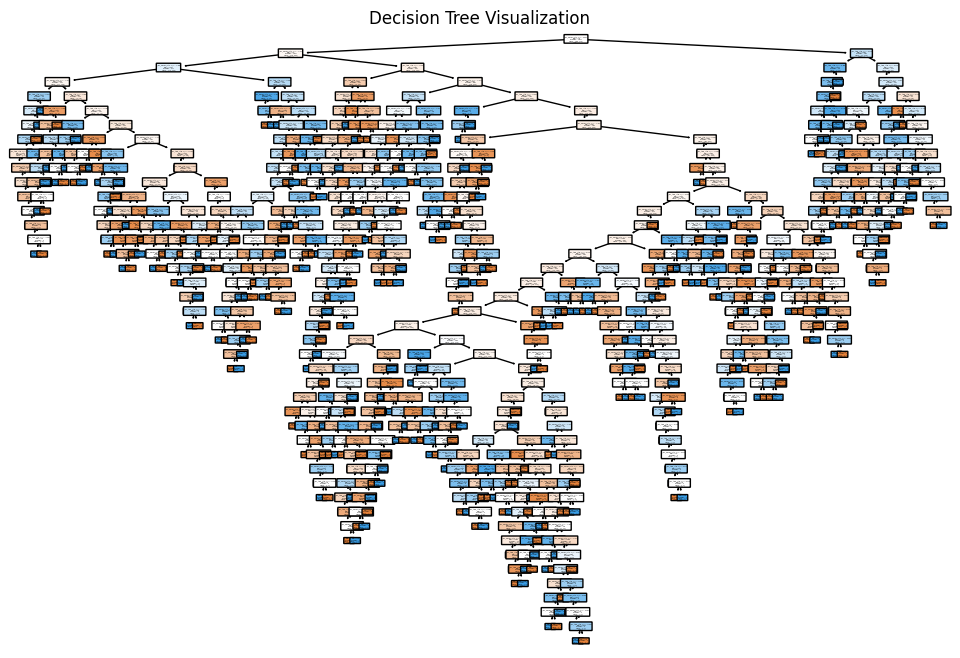

In [181]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Assuming decision_tree_model is already defined and trained

# Visualize the tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree_model, filled=True, feature_names=X_train.columns, class_names=[str(i) for i in decision_tree_model.classes_], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

In [182]:
accuracy = accuracy_score(y_test, dt1_pred)
f1 = f1_score(y_test, dt1_pred)
precision = precision_score(y_test, dt1_pred)
recall = recall_score(y_test, dt1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.4936061381074169
F1 Score: 0.4816753926701571
Precision: 0.4842105263157895
Recall: 0.4791666666666667


## Random Forest

In [183]:
rf_model = RandomForestClassifier()

k_fold = 5
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

rf_model.fit(X_train, y_train)

rf1_pred = rf_model.predict(X_test)

Cross-Validation Scores: [0.49840256 0.49201278 0.53354633 0.46153846 0.50961538]
Mean CV Accuracy: 0.4990


In [184]:
accuracy = accuracy_score(y_test, rf1_pred)
f1 = f1_score(y_test, rf1_pred)
precision = precision_score(y_test, rf1_pred)
recall = recall_score(y_test, rf1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5345268542199488
F1 Score: 0.4972375690607735
Precision: 0.5294117647058824
Recall: 0.46875


## Xgboost

In [185]:
xgboost_model = xgb.XGBClassifier(subsample=0.8, max_depth= 6, learning_rate= 0.2, colsample_bytree= 1.0)

k_fold = 5
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

xgboost_model.fit(X_train, y_train)

xgb1_pred = xgboost_model.predict(X_test)

Cross-Validation Scores: [0.50479233 0.51757188 0.56549521 0.49358974 0.51602564]
Mean CV Accuracy: 0.5195


In [186]:
accuracy = accuracy_score(y_test, xgb1_pred)
f1 = f1_score(y_test, xgb1_pred)
precision = precision_score(y_test, xgb1_pred)
recall = recall_score(y_test, xgb1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5217391304347826
F1 Score: 0.48199445983379496
Precision: 0.514792899408284
Recall: 0.453125


## SVM

In [187]:
svm_model = SVC()

k_fold = 5
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

Cross-Validation Scores: [0.52396166 0.514377   0.48881789 0.50961538 0.52564103]
Mean CV Accuracy: 0.5125


In [188]:
print("Testing Performance")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Testing Performance
Accuracy: 0.49872122762148335
F1 Score: 0.3
Precision: 0.4772727272727273
Recall: 0.21875


## Naive Bayes

In [189]:
naive_bayes_model = GaussianNB()

k_fold = 5
cv_scores = cross_val_score(naive_bayes_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

naive_bayes_model.fit(X_train, y_train)

# Make predictions
naive_bayes_pred = naive_bayes_model.predict(X_test)

# Calculate metrics
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_pred)
naive_bayes_f1 = f1_score(y_test, naive_bayes_pred)
naive_bayes_precision = precision_score(y_test, naive_bayes_pred)
naive_bayes_recall = recall_score(y_test, naive_bayes_pred)

# Print the results for Naive Bayes
print("Naive Bayes Accuracy:", naive_bayes_accuracy)
print("Naive Bayes F1 Score:", naive_bayes_f1)
print("Naive Bayes Precision:", naive_bayes_precision)
print("Naive Bayes Recall:", naive_bayes_recall)

Cross-Validation Scores: [0.45047923 0.485623   0.49840256 0.48717949 0.51602564]
Mean CV Accuracy: 0.4875
Naive Bayes Accuracy: 0.5268542199488491
Naive Bayes F1 Score: 0.17777777777777778
Naive Bayes Precision: 0.6060606060606061
Naive Bayes Recall: 0.10416666666666667


## KNN

In [190]:
knn_model = KNeighborsClassifier()

k_fold = 5
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

knn_model.fit(X_train, y_train)

# Make predictions
knn_pred = knn_model.predict(X_test)

# Calculate metrics
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)

# Print the results for K-nearest Neighbors
print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1)
print("KNN Precision:", knn_precision)
print("KNN Recall:", knn_recall)

Cross-Validation Scores: [0.52715655 0.48242812 0.51118211 0.4775641  0.48076923]
Mean CV Accuracy: 0.4958
KNN Accuracy: 0.5677749360613811
KNN F1 Score: 0.5369863013698629
KNN Precision: 0.5664739884393064
KNN Recall: 0.5104166666666666


# Models trained on Lead 1+2+3 ...+12 = 132 features using Standard Normalization

In [191]:
merged_df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/new_features_merged.csv")
merged_df.drop("Unnamed: 0", axis=1, inplace=True)
merged_df.dropna(inplace=True)

In [192]:
# merged_df = merged_df[merged_df["lead_id"] < 4]
merged_df

,patient_id,lead_id,edr_time_ratio,edr_energy_ratio,target
0,0,1,1.007608,1.011732,1
1,0,2,0.876788,0.744761,1
2,0,3,0.959859,0.946903,1
3,0,4,1.140411,1.100461,1
4,0,5,1.045801,0.947137,1
...,...,...,...,...,...
23027,2163,8,0.953257,0.937737,0
23028,2163,9,1.879499,1.736153,0
23029,2163,10,1.033777,1.018536,0
23030,2163,11,1.602314,1.578354,0


In [193]:
merged_df.columns

Index(['patient_id', 'lead_id', 'edr_time_ratio', 'edr_energy_ratio',
       'target'],
      dtype='object')

In [194]:
pivoted_df = merged_df.pivot(index='patient_id', columns='lead_id',\
                             values=['edr_time_ratio', 'edr_energy_ratio'])
pivoted_df.sort_index(axis=1, level=1, inplace=True)


In [195]:
pivoted_df

,edr_energy_ratio,edr_time_ratio,edr_energy_ratio,edr_time_ratio,edr_energy_ratio,edr_time_ratio,edr_energy_ratio,edr_time_ratio,edr_energy_ratio,edr_time_ratio,...,edr_energy_ratio,edr_time_ratio,edr_energy_ratio,edr_time_ratio,edr_energy_ratio,edr_time_ratio,edr_energy_ratio,edr_time_ratio,edr_energy_ratio,edr_time_ratio
lead_id,1,1,2,2,3,3,4,4,5,5,...,8,8,9,9,10,10,11,11,12,12
patient_id,,,,,,,,,,,,,,,,,,,,,
0,1.011732,1.007608,0.744761,0.876788,0.946903,0.959859,1.100461,1.140411,0.947137,1.045801,...,1.085941,1.158885,0.908054,0.922386,0.968451,0.978972,0.926015,0.957274,0.858680,0.952977
1,0.786049,0.942913,0.840727,0.959791,NaN,NaN,1.093093,1.219209,0.747169,0.930808,...,1.305924,1.404188,1.344509,1.406745,0.858602,0.881351,0.910001,0.937862,0.898479,0.964186
2,1.089178,1.237727,NaN,NaN,NaN,NaN,1.093830,1.131625,NaN,NaN,...,1.200571,1.181453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.149821,1.001017,0.942802,0.910451,0.847680,0.696311,1.708900,1.700943,0.693848,0.677688,...,0.447021,0.442493,3.326584,3.331148,1.154804,1.110746,1.423961,1.297454,1.087794,1.021021
4,0.748991,0.741321,0.891510,0.829132,2.209482,2.116705,2.002123,2.053719,1.031301,1.074553,...,0.950446,0.959851,NaN,NaN,1.904423,1.927476,1.341023,1.321160,1.670057,1.628468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,0.722308,0.725112,1.146189,1.118001,1.527741,1.374916,1.330972,1.296385,0.489420,0.472295,...,0.617128,0.617318,0.861954,0.885773,1.089354,1.154197,1.804689,1.909613,1.137907,1.055215
2160,0.839059,0.805867,0.819114,0.766917,1.235104,0.987741,1.365001,1.329075,0.777736,0.741553,...,1.087579,1.047474,1.246371,1.188343,1.237658,1.166770,1.207580,1.148097,1.162067,1.101577


In [196]:
pivoted_df = pivoted_df.reset_index()
pivoted_df

patient_id edr_energy_ratio edr_time_ratio edr_energy_ratio  \
lead_id                           1              1                2   
0                0         1.011732       1.007608         0.744761   
1                1         0.786049       0.942913         0.840727   
2                2         1.089178       1.237727              NaN   
3                3         1.149821       1.001017         0.942802   
4                4         0.748991       0.741321         0.891510   
...            ...              ...            ...              ...   
2157          2159         0.722308       0.725112         1.146189   
2158          2160         0.839059       0.805867         0.819114   
2159          2161         1.142280       1.028140         0.926035   
2160          2162         0.582093       0.665277         0.950095   
2161          2163         1.035460       1.063577         1.513601   

        edr_time_ratio edr_energy_ratio edr_time_ratio edr_energy_ratio  \
lead_id              2                3              3                4   
0             0.876788         0.946903       0.959859         1.100461   
1             0.959791              NaN            NaN         1.093093   
2                  NaN              NaN            NaN         1.093830   
3             0.910451         0.847680       0.696311         1.708900   
4             0.829132         2.209482       2.116705         2.002123   
...                ...              ...            ...              ...   
2157          1.118001         1.527741       1.374916         1.330972   
2158          0.766917         1.235104       0.987741         1.365001   
2159          0.950140         0.806989       0.787163         1.084140   
2160          0.989151         0.829396       1.174211         1.262083   
2161          1.652199         1.550729       1.604211         0.384325   

        edr_time_ratio edr_energy_ratio  ...           edr_time_ratio  \
lead_id              4                5  ...         8              8   
0             1.140411         0.947137  ...  1.085941       1.158885   
1             1.219209         0.747169  ...  1.305924       1.404188   
2             1.131625              NaN  ...  1.200571       1.181453   
3             1.700943         0.693848  ...  0.447021       0.442493   
4             2.053719         1.031301  ...  0.950446       0.959851   
...                ...              ...  ...       ...            ...   
2157          1.296385         0.489420  ...  0.617128       0.617318   
2158          1.329075         0.777736  ...  1.087579       1.047474   
2159          1.072417         1.184636  ...  0.945163       0.931419   
2160          1.342569         0.523371  ...  0.635082       0.624247   
2161          0.346134         0.747164  ...  0.937737       0.953257   

        edr_energy_ratio edr_time_ratio edr_energy_ratio edr_time_ratio  \
lead_id                9              9               10             10   
0               0.908054       0.922386         0.968451       0.978972   
1               1.344509       1.406745         0.858602       0.881351   
2                    NaN            NaN              NaN            NaN   
3               3.326584       3.331148         1.154804       1.110746   
4                    NaN            NaN         1.904423       1.927476   
...                  ...            ...              ...            ...   
2157            0.861954       0.885773         1.089354       1.154197   
2158            1.246371       1.188343         1.237658       1.166770   
2159            0.983576       1.004397         0.775403       0.743508   
2160            1.133421       1.150344         1.074078       1.110722   
2161            1.736153       1.879499         1.018536       1.033777   

        edr_energy_ratio edr_time_ratio edr_energy_ratio edr_time_ratio  
lead_id               11             11               12             12  
0               0.926015       0.9

In [197]:
merged_df = pd.merge(pivoted_df, target_df, on='patient_id', how='inner')

<ipython-input-197-2fe9fba29447>:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  merged_df = pd.merge(pivoted_df, target_df, on='patient_id', how='inner')


In [198]:
merged_df.dropna(inplace=True)

In [199]:
merged_df.columns

Index([            'patient_id',       ('patient_id', ''),
        ('edr_energy_ratio', 1),    ('edr_time_ratio', 1),
        ('edr_energy_ratio', 2),    ('edr_time_ratio', 2),
        ('edr_energy_ratio', 3),    ('edr_time_ratio', 3),
        ('edr_energy_ratio', 4),    ('edr_time_ratio', 4),
        ('edr_energy_ratio', 5),    ('edr_time_ratio', 5),
        ('edr_energy_ratio', 6),    ('edr_time_ratio', 6),
        ('edr_energy_ratio', 7),    ('edr_time_ratio', 7),
        ('edr_energy_ratio', 8),    ('edr_time_ratio', 8),
        ('edr_energy_ratio', 9),    ('edr_time_ratio', 9),
       ('edr_energy_ratio', 10),   ('edr_time_ratio', 10),
       ('edr_energy_ratio', 11),   ('edr_time_ratio', 11),
       ('edr_energy_ratio', 12),   ('edr_time_ratio', 12),
                       'target'],
      dtype='object')

In [200]:
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

merged_df = merged_df.iloc[:,2:]

X = merged_df.drop(["target"], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,"(edr_energy_ratio, 1)","(edr_time_ratio, 1)","(edr_energy_ratio, 2)","(edr_time_ratio, 2)","(edr_energy_ratio, 3)","(edr_time_ratio, 3)","(edr_energy_ratio, 4)","(edr_time_ratio, 4)","(edr_energy_ratio, 5)","(edr_time_ratio, 5)",...,"(edr_energy_ratio, 8)","(edr_time_ratio, 8)","(edr_energy_ratio, 9)","(edr_time_ratio, 9)","(edr_energy_ratio, 10)","(edr_time_ratio, 10)","(edr_energy_ratio, 11)","(edr_time_ratio, 11)","(edr_energy_ratio, 12)","(edr_time_ratio, 12)"
0,-0.323924,-0.261388,-0.362618,-0.314122,-0.130695,-0.108185,-0.153199,-0.137934,-0.076217,-0.027093,...,0.001269,0.013845,-0.068034,-0.071139,0.135590,0.139865,-0.013776,0.009450,-0.204535,-0.194425
1,0.045156,0.167566,-0.502278,-0.400674,0.099978,0.288028,-0.095620,-0.051964,-0.074353,0.025425,...,-0.444703,-0.428706,-0.283608,-0.226259,-0.520789,-0.467249,-0.872620,-0.817177,-0.185052,-0.163230
2,0.256822,0.129562,-0.200137,-0.219250,0.254846,0.220340,-0.365771,-0.312630,0.259273,0.079723,...,-0.339836,-0.244198,-0.460453,-0.416096,-0.342952,-0.293298,-0.570523,-0.498037,-0.058399,-0.021186
3,0.037604,-0.047496,0.651185,0.612265,0.104339,0.066394,0.371070,0.309867,-0.125100,-0.183303,...,-0.192998,-0.222116,-0.299817,-0.316251,-0.247722,-0.256918,-0.590193,-0.591429,-0.328922,-0.344929
4,-0.052437,-0.169453,-0.543498,-0.584115,-0.025567,-0.152805,-0.297065,-0.291979,0.469009,0.267838,...,0.028823,-0.007397,-0.416293,-0.461180,-0.315381,-0.345604,-0.311963,-0.366285,-0.250106,-0.286864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,0.092526,0.141467,1.652999,1.663512,0.024251,0.109803,-0.289613,-0.246773,-0.052027,-0.047530,...,-0.433938,-0.344932,-0.687787,-0.596916,0.007056,0.056957,0.495650,0.417631,-0.100225,-0.043209
1215,0.072422,-0.171886,-0.116804,-0.121640,0.965644,0.899188,-0.441700,-0.420049,-0.051531,-0.223240,...,-0.654826,-0.682341,-0.485092,-0.526175,-0.284679,-0.294911,-0.417090,-0.437882,-0.415373,-0.422890
1216,0.082274,0.133627,0.640053,0.984677,0.572006,0.653782,-0.567545,-0.437195,0.915413,0.989423,...,0.760491,0.670687,0.293569,0.245349,-0.164485,-0.168924,2.270156,2.330228,1.779970,1.813591
1217,-0.239891,-0.173744,0.135378,0.027783,0.213669,0.050571,0.104243,0.054966,-0.263935,-0.224635,...,0.042158,0.043643,-0.147405,-0.142557,-0.053797,-0.079132,0.018743,-0.083388,0.008593,-0.040591


## Training and Testing on Complete Data

In [201]:
y = merged_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [202]:
len(X_train), len(X_test)

(975, 244)

In [203]:
y.value_counts()

0    611
1    608
Name: target, dtype: int64

## Logistic Regression

In [204]:
logress_model = LogisticRegression()

k_fold = 5
cv_scores = cross_val_score(logress_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

logress_model.fit(X_train, y_train)

log1_pred = logress_model.predict(X_test)

Cross-Validation Scores: [0.54871795 0.46666667 0.52307692 0.4974359  0.53333333]
Mean CV Accuracy: 0.5138


In [205]:
accuracy = accuracy_score(y_test, log1_pred)
f1 = f1_score(y_test, log1_pred)
precision = precision_score(y_test, log1_pred)
recall = recall_score(y_test, log1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5368852459016393
F1 Score: 0.4644549763033175
Precision: 0.6805555555555556
Recall: 0.35251798561151076


## Decision Trees

In [206]:
decision_tree_model = DecisionTreeClassifier()

k_fold = 5
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

decision_tree_model.fit(X_train, y_train)

dt1_pred = decision_tree_model.predict(X_test)

Cross-Validation Scores: [0.4974359  0.55384615 0.50769231 0.54871795 0.47179487]
Mean CV Accuracy: 0.5159


In [207]:
accuracy = accuracy_score(y_test, dt1_pred)
f1 = f1_score(y_test, dt1_pred)
precision = precision_score(y_test, dt1_pred)
recall = recall_score(y_test, dt1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5245901639344263
F1 Score: 0.5396825396825398
Precision: 0.6017699115044248
Recall: 0.4892086330935252


## Random Forest

In [208]:
rf_model = RandomForestClassifier()

k_fold = 5
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

rf_model.fit(X_train, y_train)

rf1_pred = rf_model.predict(X_test)

Cross-Validation Scores: [0.50769231 0.56410256 0.50769231 0.55897436 0.50769231]
Mean CV Accuracy: 0.5292


In [209]:
accuracy = accuracy_score(y_test, rf1_pred)
f1 = f1_score(y_test, rf1_pred)
precision = precision_score(y_test, rf1_pred)
recall = recall_score(y_test, rf1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5204918032786885
F1 Score: 0.4845814977973568
Precision: 0.625
Recall: 0.39568345323741005


## Xgboost

In [210]:
xgboost_model = xgb.XGBClassifier(subsample=0.8, max_depth= 6, learning_rate= 0.2, colsample_bytree= 1.0)

k_fold = 5
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

xgboost_model.fit(X_train, y_train)

xgb1_pred = xgboost_model.predict(X_test)

Cross-Validation Scores: [0.49230769 0.51282051 0.48717949 0.56410256 0.49230769]
Mean CV Accuracy: 0.5097


In [211]:
accuracy = accuracy_score(y_test, xgb1_pred)
f1 = f1_score(y_test, xgb1_pred)
precision = precision_score(y_test, xgb1_pred)
recall = recall_score(y_test, xgb1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5286885245901639
F1 Score: 0.5267489711934157
Precision: 0.6153846153846154
Recall: 0.460431654676259


## SVM

In [212]:
svm_model = SVC()

k_fold = 5
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

Cross-Validation Scores: [0.51794872 0.52820513 0.46153846 0.53846154 0.56923077]
Mean CV Accuracy: 0.5231


In [213]:
print("Testing Performance")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Testing Performance
Accuracy: 0.48770491803278687
F1 Score: 0.358974358974359
Precision: 0.625
Recall: 0.2517985611510791


## Naive Bayes

In [214]:
naive_bayes_model = GaussianNB()

k_fold = 5
cv_scores = cross_val_score(naive_bayes_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

naive_bayes_model.fit(X_train, y_train)

# Make predictions
naive_bayes_pred = naive_bayes_model.predict(X_test)

# Calculate metrics
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_pred)
naive_bayes_f1 = f1_score(y_test, naive_bayes_pred)
naive_bayes_precision = precision_score(y_test, naive_bayes_pred)
naive_bayes_recall = recall_score(y_test, naive_bayes_pred)

# Print the results for Naive Bayes
print("Naive Bayes Accuracy:", naive_bayes_accuracy)
print("Naive Bayes F1 Score:", naive_bayes_f1)
print("Naive Bayes Precision:", naive_bayes_precision)
print("Naive Bayes Recall:", naive_bayes_recall)

Cross-Validation Scores: [0.55384615 0.50769231 0.4974359  0.52307692 0.58974359]
Mean CV Accuracy: 0.5344
Naive Bayes Accuracy: 0.46311475409836067
Naive Bayes F1 Score: 0.24277456647398846
Naive Bayes Precision: 0.6176470588235294
Naive Bayes Recall: 0.1510791366906475


## KNN

In [215]:
knn_model = KNeighborsClassifier()

k_fold = 5
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

knn_model.fit(X_train, y_train)

# Make predictions
knn_pred = knn_model.predict(X_test)

# Calculate metrics
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)

# Print the results for K-nearest Neighbors
print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1)
print("KNN Precision:", knn_precision)
print("KNN Recall:", knn_recall)

Cross-Validation Scores: [0.55384615 0.47692308 0.56923077 0.4974359  0.48717949]
Mean CV Accuracy: 0.5169
KNN Accuracy: 0.5614754098360656
KNN F1 Score: 0.5560165975103735
KNN Precision: 0.6568627450980392
KNN Recall: 0.48201438848920863
